In [92]:
import os
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from matplotlib import pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import pandas as pd
import soundfile as sf
import IPython
from scipy.fft import fft, fftfreq
import torch
import torchaudio
from torchaudio import transforms
import torch.nn.functional as F
from torch.nn import init
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
import random 
from pathlib import Path


%matplotlib inline

In [93]:
def print_plot_play(x, Fs, text=''):
    """1. Prints information about an audio singal, 2. plots the waveform, and 3. Creates player
    
    Notebook: C1/B_PythonAudio.ipynb
    
    Args: 
        x: Input signal
        Fs: Sampling rate of x    
        text: Text to print
    """
    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(8, 2))
    plt.plot(x, color='gray')
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))
    
def apply_fft(signal): 
    N = len(signal)
    Y = np.fft.fft(signal) # FFT function from numpy
    Y_k = Y / N
    Y_k[1:] = 2*Y_k[1:] # need to take the single-sided spectrum only
    Pxx = np.abs(Y_k) # be sure to get rid of imaginary part

    f = Fs*np.arange(int(N/2))/N; # frequency vector
    # plotting
    fig,ax = plt.subplots()
    plt.plot(f,Pxx[0:int(N/2)],linewidth=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.ylabel('Amplitude')
    plt.xlabel('Frequency [Hz]')
    plt.show()
    return Y

def apply_ifft_with_filter(frequencies, N, threadhold = 0.00002):
    Y_k = Y / N
    Y_k[1:] = 2*Y_k[1:] # need to take the single-sided spectrum only
    Pxx = np.abs(Y_k) # be sure to get rid of imaginary part
    
    Y_100 = np.multiply(Y_k, (Pxx > threadhold) * 1)
    Pxx_100 = np.multiply(Pxx, (Pxx > threadhold) * 1)

    fig,ax = plt.subplots()
    plt.plot(f,Pxx_100[0:int(N/2)],linewidth=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.ylabel('Amplitude')
    plt.xlabel('Frequency [Hz]')
    plt.show()

    isound = np.fft.ifft(Y_100)
    return isound


def preprocess_audio(filename):
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav') 

OGG file:  Fs = 44100, x.shape = (1323119,), x.dtype = float64


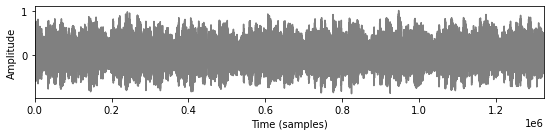

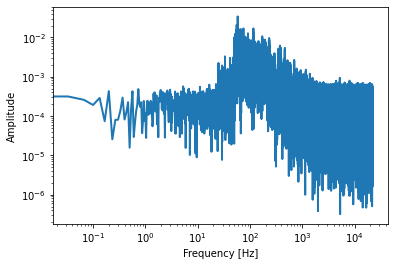

NameError: name 'Y' is not defined

In [94]:
x, Fs = librosa.load('/Users/pmarchenko/Desktop/titanik/music_classification/data/train/000000.ogg', sr=None)
#print_plot_play(x=x, Fs=Fs, text='OGG file: ')


y = x + np.random.uniform(-0.2,0.2, x.shape[0])
print_plot_play(x=y, Fs=Fs, text='OGG file: ')
#librosa.display.waveshow(y, sr=Fs)


audio = 0.5 * np.cos(2 * np.pi * 1000 * np.arange(0, Fs) / Fs) + 0.5 * np.random.uniform(-1,1, Fs)
#print_plot_play(x=y,Fs=Fs,text='Generated signal: ')

fft_audio = apply_fft(y)
ifft_audio = apply_ifft_with_filter(fft_audio, len(y) ,0.00005)

print_plot_play(x=ifft_audio,Fs=Fs,text='Generated signal: ')

In [ ]:
mel_sgram1 = spectro_gram(x, Fs, n_fft = 2048)

librosa.display.specshow(mel_sgram1, sr=Fs, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [ ]:
class AudioUtils(object):
    
    @staticmethod
    def read_audio_librosa(file_path, sr): 
        signal, fs = librosa.load(file_path, sr=sr)
        return np.array(signal)
    
    @staticmethod
    def pad_audio_librosa(signal, sr, duration_sec): 
        desired_size = sr * duration_sec
        return np.resize(signal, desired_size)
    
    @staticmethod
    def mel_sgram_librosa(sig, sr = 44100, n_fft=2048, hop_len=None, top_db = 120):
        sgram = librosa.stft(sig, n_fft=n_fft, hop_length=hop_len)
    
        sgram_mag, _ = librosa.magphase(sgram)
        mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr, n_fft=n_fft, hop_length=hop_len)

        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        return mel_sgram
    
    
    @staticmethod
    def read_audio_torch(file_path): 
        sig, sr = torchaudio.load(file_path)
        return (sig, sr)
    
    @staticmethod
    def rechannel_audio_torch(aud, new_channel):
        sig, sr = aud

        if (sig.shape[0] == new_channel):
          # Nothing to do
          return aud

        if (new_channel == 1):
          # Convert from stereo to mono by selecting only the first channel
          resig = sig[:1, :]
        else:
          # Convert from mono to stereo by duplicating the first channel
          resig = torch.cat([sig, sig])
        return (resig, sr)
    
    @staticmethod
    def resample_audio_tourch(aud, newsr):
        sig, sr = aud
        if (sr == newsr):
          # Nothing to do
          return aud
        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])
        return (resig, newsr)
    
    @staticmethod
    def pad_audio_torch(aud, duration_sec):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr * duration_sec

        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)
        return (sig, sr)
    
    @staticmethod
    def pitch_shift_audio_torch(aud, shift_limit = random.randint(-999, 999)):
        sig,sr = aud
        sig_shift, sr = torchaudio.sox_effects.apply_effects_tensor(sig, sr, effects = [['pitch', str(shift_limit)], ['gain', '-n'], ['rate', str(sr)]], channels_first=True)
        return (sig_shift, sr)
    
    @staticmethod
    def make_quiter_audio_torch(aud, quite_in_db = random.randint(-5, -1)):
        sig,sr = aud
        sig = sig + quite_in_db
        return (sig, sr)
    
    @staticmethod
    def time_shift_audio_torch(aud, shift_limit): 
        sig,sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)
    
    @staticmethod
    def sub_audio_torch(aud, sub_audio_dur_sec = 5):
        sig,sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * sig_len)
        return AudioUtils.pad_audio_torch((sig.roll(shift_amt), sr), sub_audio_dur_sec)
    
    @staticmethod
    def mel_sgram_tourch(aud, sr = 44100, n_mels=64, n_fft=1024, hop_len=None, top_db = 120):
        sig,sr = aud
        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)
    
    @staticmethod
    def mel_sgram_augment_tourch(spec, max_mask_pct=0.2, n_freq_masks=2, n_time_masks=2):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
          aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
          aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec
    

In [95]:

class SoundDS(Dataset):
  def __init__(self, base_path, dataset_type, lib = 'torch', filter_not_existing = True, sub_aud_dur_sec = None, make_quiter = False, pitch_shift_enabled = False):
    self.base_path = base_path
    self.dataset_type = dataset_type
    self.sr = 44100
    self.audio_duration_sec = 30
    self.channel = 2
    self.shift_pct = 0.1
    self.lib = lib
    self.sub_aud_dur_sec = sub_aud_dur_sec
    self.pitch_shift_enabled = pitch_shift_enabled
    self.make_quiter = make_quiter
    
    self.data = pd.read_csv(os.path.join(base_path, dataset_type + '.csv')) #, nrows = max_samples , index_col = 'song_id'
    
    def not_exist_filter(row):
        return Path(os.path.join(base_path, row['filepath'])).exists()
    
    if(filter_not_existing):   
        self.data = self.data[self.data.apply(not_exist_filter, axis=1) ]
    self.data.index = range(len(self.data.index))  
    
  def __len__(self):
    return len(self.data)

  def increase_shift_pct(self):
    self.shift_pct = self.shift_pct + 0.1

  def get_item_librosa(self, idx):
    if 'genre_id' in self.data.columns:
        class_id = self.data.loc[idx, 'genre_id']
    else: 
        class_id = -1000 # not existing
    song_id = self.data.loc[idx, 'song_id']
    signal = AudioUtils.read_audio_librosa(os.path.join(self.base_path, self.data.loc[idx, 'filepath']), self.sr)
    signal_pad = AudioUtils.pad_audio_librosa(signal, self.sr, self.audio_duration_sec)
    sgram = AudioUtils.mel_sgram_librosa(signal_pad, self.sr)
    
    sgram = AudioUtils.mel_sgram_librosa(signal_pad, self.sr)
    return torch.tensor(sgram.reshape(sgram.shape[1], sgram.shape[0])), torch.tensor(class_id), song_id

  def get_item_tourch(self, idx):
    if 'genre_id' in self.data.columns:
        class_id = self.data.loc[idx, 'genre_id']
    else: 
        class_id = -1000 # not existing
    song_id = self.data.loc[idx, 'song_id']
    
    aud = AudioUtils.read_audio_torch(os.path.join(self.base_path, self.data.loc[idx, 'filepath']))
    aud_resample = AudioUtils.resample_audio_tourch(aud, self.sr)
    aud_rechannel = AudioUtils.rechannel_audio_torch(aud_resample, self.channel)
    aud_pad = AudioUtils.pad_audio_torch(aud_rechannel, self.audio_duration_sec)
    
    aud_augment = AudioUtils.time_shift_audio_torch(aud_pad, self.shift_pct)
    
    if(self.sub_aud_dur_sec is not None):
        aud_augment = AudioUtils.sub_audio_torch(aud_augment, self.sub_aud_dur_sec)
    
    if(self.pitch_shift_enabled): 
        aud_augment = AudioUtils.pitch_shift_audio_torch(aud_augment)
    
    if(self.make_quiter): 
        aud_augment = AudioUtils.make_quiter_audio_torch(aud_augment)
    
    sgram = AudioUtils.mel_sgram_tourch(aud=aud_augment, sr=self.sr)
    sgram_augment = AudioUtils.mel_sgram_augment_tourch(sgram)
    return sgram, torch.tensor(class_id), song_id

  def __getitem__(self, idx):  
    if(self.lib == 'torch'):
        res = self.get_item_tourch(idx)
    else:
        res = self.get_item_librosa(idx)
    return res
   


In [96]:
# create data loader class (then add augmentation, sampling features, etc...)
# data preparation: augmentation
# signal (30 * 44100 features) -> spectogram of the signal (around 5000 features) -> 
# (CNN) or (Sequence model)  or / -> (reg classifier) -> 19 feature output vector

from torch.utils.data import random_split

soundTrainDS = SoundDS("/Users/pmarchenko/Desktop/titanik/music_classification/data", "train", make_quiter = True, sub_aud_dur_sec = 15)
soundTestDS = SoundDS("/Users/pmarchenko/Desktop/titanik/music_classification/data", "test")

# Random split of 80:20 between training and validation
num_items = len(soundTrainDS)
num_train = round(num_items * 0.9)
num_val = num_items - num_train
train_ds, val_ds = random_split(soundTrainDS, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

# train DL
dl = torch.utils.data.DataLoader(soundTrainDS, batch_size=16, shuffle=True)

#prediction dl
test_dl = torch.utils.data.DataLoader(soundTestDS, batch_size=16, shuffle=False)

In [97]:
print(len(soundTestDS))

soundTrainDS.data
print(soundTrainDS.get_item_librosa(16248)[0].shape)
print(soundTrainDS.get_item_tourch(16248)[0].shape)
soundTrainDS.get_item_tourch(16249)[0].detach().cpu().numpy().reshape(128, 2584)

librosa.display.specshow(soundTrainDS.get_item_librosa(16248)[0], sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

plt.figure()
# soundTrainDS.increase_shift_pct()

# librosa.display.specshow(soundTrainDS.get_item(16312)[0], sr=Fs, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')

5076
torch.Size([2584, 128])
torch.Size([2, 64, 1292])


ValueError: cannot reshape array of size 165376 into shape (128,2584)

In [98]:
import torch
import torch.optim as optim
import torch.nn as nn
# from torchviz import make_dot

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [99]:
import torch.nn.functional as F
from torch.nn import init

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=19)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x    
    
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)

next(myModel.parameters()).device    

device(type='cpu')

In [101]:
from torchvision.models import resnet34
# ----------------------------
# Audio Classification Model Pre Trained
# ----------------------------
class AudioClassifierResNet34(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet_model = resnet34(pretrained=False)
        self.resnet_model.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet_model.fc = nn.Linear(in_features=512, out_features=19)

    def forward(self, x):
        return self.resnet_model(x)    
    
myModelPreTrained = AudioClassifierResNet34()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModelPreTrained = myModelPreTrained.to(device)
myModelPreTrained
next(myModelPreTrained.parameters()).device    

device(type='cpu')

In [102]:
myModel

AudioClassifier(
  (conv1): Conv2d(2, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ap): AdaptiveAvgPool2d(output_size=1)
  (lin): Linear(in_features=64, out_features=19, bias=True)
  (conv): Sequential(
    (0): Conv2d(2, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, mome

In [103]:
myModelPreTrained

AudioClassifierResNet34(
  (resnet_model): ResNet(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [104]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    train_dl.dataset.increase_shift_pct()    
    running_loss = 0.0
    
    actual = np.array([]).astype(int)
    predicted = np.array([]).astype(int)

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        
        inputs, labels = data[0].to(device), data[1].to(device)
    
        
        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
#         print(inputs.shape)
#         print(labels.shape)
#         print(outputs.shape)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss 
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        actual = np.append(actual, labels.detach().cpu().numpy())
        predicted = np.append(predicted, prediction.detach().cpu().numpy())
    
        if i % 10 == 0:    # print every 10 mini-batches
            metrics = precision_recall_fscore_support(actual, predicted, average='weighted',zero_division=1)
            print('[%d, %5d] loss: %.3f, precision: %.3f, recall: %.3f, f1_score: %.3f' % (epoch + 1, i + 1, running_loss / 10, metrics[0], metrics[1], metrics[2]))
    
    # Print stats at the end of the epoch
    metrics = precision_recall_fscore_support(actual, predicted, average='weighted')
    print('Loss: %.3f, Precision: %.3f, Recall: %.3f, F1_score: %.3f' % (running_loss / 10, metrics[0], metrics[1], metrics[2]))

  print('Finished Training')
  


In [105]:
# ----------------------------
# Inference
# ----------------------------
def inference(model, val_dl):

  actual = np.array([]).astype(int)
  predicted = np.array([]).astype(int)

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device) 

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
    
      # Count of predictions that matched the target label
      actual = np.append(actual, labels.detach().cpu().numpy())
      predicted = np.append(predicted, prediction.detach().cpu().numpy())

    
  metrics = precision_recall_fscore_support(actual, predicted, average='weighted')
  print('Precision: %.3f, Recall: %.3f, F1_score: %.3f' % (metrics[0], metrics[1], metrics[2]))
  return metrics

In [106]:
# Run inference on trained model with the validation set
#inference(myModel, val_dl)

In [107]:
# ----------------------------
# Predictions 
# ----------------------------
def predictions(model, predictions_dl):
  
  song_ids = np.array([]).astype(int)
  predicted = np.array([]).astype(int)

  # Disable gradient updates
  with torch.no_grad():
    for data in predictions_dl:    
      # Get the input features and target labels, and put them on the GPU
      inputs, songs = data[0].to(device), data[2].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      song_ids = np.append(song_ids, songs.detach().cpu().numpy())
      predicted = np.append(predicted, prediction.detach().cpu().numpy()) 
  
  s1 = pd.Series(song_ids, name='song_id')  
  s2 = pd.Series(predicted, name='genre_id')
  res = pd.concat([s1, s2], axis=1)

  soundTestDS2 = SoundDS("/Users/pmarchenko/Desktop/titanik/music_classification/data", "test", filter_not_existing = False)
  final = pd.merge(soundTestDS2.data, res, on = 'song_id', how = 'outer')

  s1 = final['song_id']
  s2 = pd.Series(final['genre_id'].values.astype(int), name='genre_id')
  pd.concat([s1, s2], axis=1).to_csv('/Users/pmarchenko/Desktop/titanik/music_classification/submission.csv', index=False)
  return pd.concat([s1, s2], axis=1)




In [108]:
train_ds = SoundDS("/Users/pmarchenko/Desktop/titanik/music_classification/data", "train") #, make_quiter = True, sub_aud_dur_sec = 15
test_ds = SoundDS("/Users/pmarchenko/Desktop/titanik/music_classification/data", "test")

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

In [112]:
num_epochs = 2
training(myModelPreTrained, train_dl, num_epochs)

[1,     1] loss: 0.158, precision: 0.604, recall: 0.438, f1_score: 0.425
[1,    11] loss: 1.260, precision: 0.622, recall: 0.619, f1_score: 0.612
[1,    21] loss: 2.467, precision: 0.622, recall: 0.613, f1_score: 0.606
[1,    31] loss: 3.649, precision: 0.615, recall: 0.607, f1_score: 0.597
[1,    41] loss: 4.784, precision: 0.611, recall: 0.605, f1_score: 0.594
[1,    51] loss: 5.784, precision: 0.616, recall: 0.610, f1_score: 0.599
[1,    61] loss: 6.827, precision: 0.620, recall: 0.612, f1_score: 0.600
[1,    71] loss: 8.018, precision: 0.614, recall: 0.607, f1_score: 0.596
[1,    81] loss: 9.199, precision: 0.612, recall: 0.603, f1_score: 0.591
[1,    91] loss: 10.334, precision: 0.616, recall: 0.607, f1_score: 0.595
[1,   101] loss: 11.489, precision: 0.612, recall: 0.606, f1_score: 0.594
[1,   111] loss: 12.652, precision: 0.611, recall: 0.605, f1_score: 0.594
[1,   121] loss: 13.874, precision: 0.604, recall: 0.604, f1_score: 0.592
[1,   131] loss: 15.249, precision: 0.602, reca

[1,  1111] loss: 145.515, precision: 0.550, recall: 0.553, f1_score: 0.540
[1,  1121] loss: 147.093, precision: 0.550, recall: 0.553, f1_score: 0.540
[1,  1131] loss: 148.510, precision: 0.549, recall: 0.552, f1_score: 0.539
[1,  1141] loss: 149.765, precision: 0.550, recall: 0.553, f1_score: 0.540
[1,  1151] loss: 151.057, precision: 0.550, recall: 0.553, f1_score: 0.540
[1,  1161] loss: 152.514, precision: 0.549, recall: 0.552, f1_score: 0.539
[1,  1171] loss: 153.862, precision: 0.549, recall: 0.552, f1_score: 0.539
[1,  1181] loss: 155.311, precision: 0.549, recall: 0.552, f1_score: 0.539
[1,  1191] loss: 156.638, precision: 0.549, recall: 0.552, f1_score: 0.539
[1,  1201] loss: 157.974, precision: 0.549, recall: 0.552, f1_score: 0.539
[1,  1211] loss: 159.439, precision: 0.549, recall: 0.552, f1_score: 0.539
[1,  1221] loss: 160.690, precision: 0.549, recall: 0.552, f1_score: 0.539
[1,  1231] loss: 161.981, precision: 0.549, recall: 0.552, f1_score: 0.539
[1,  1241] loss: 163.255,

/Users/pmarchenko/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 163.655, Precision: 0.545, Recall: 0.553, F1_score: 0.539
[2,     1] loss: 0.099, precision: 0.682, recall: 0.562, f1_score: 0.520
[2,    11] loss: 1.517, precision: 0.562, recall: 0.534, f1_score: 0.514
[2,    21] loss: 2.847, precision: 0.533, recall: 0.521, f1_score: 0.498
[2,    31] loss: 4.028, precision: 0.564, recall: 0.548, f1_score: 0.533
[2,    41] loss: 5.227, precision: 0.550, recall: 0.546, f1_score: 0.532
[2,    51] loss: 6.656, precision: 0.546, recall: 0.540, f1_score: 0.527
[2,    61] loss: 8.057, precision: 0.550, recall: 0.537, f1_score: 0.525
[2,    71] loss: 9.426, precision: 0.538, recall: 0.533, f1_score: 0.520
[2,    81] loss: 10.675, precision: 0.541, recall: 0.535, f1_score: 0.522
[2,    91] loss: 12.070, precision: 0.531, recall: 0.530, f1_score: 0.517
[2,   101] loss: 13.343, precision: 0.533, recall: 0.533, f1_score: 0.520
[2,   111] loss: 14.721, precision: 0.533, recall: 0.533, f1_score: 0.521
[2,   121] loss: 16.010, precision: 0.537, recall: 0.535

[2,  1101] loss: 137.526, precision: 0.568, recall: 0.572, f1_score: 0.560
[2,  1111] loss: 138.536, precision: 0.569, recall: 0.573, f1_score: 0.561
[2,  1121] loss: 139.799, precision: 0.570, recall: 0.574, f1_score: 0.561
[2,  1131] loss: 140.918, precision: 0.570, recall: 0.574, f1_score: 0.562
[2,  1141] loss: 142.027, precision: 0.571, recall: 0.575, f1_score: 0.562
[2,  1151] loss: 143.088, precision: 0.571, recall: 0.575, f1_score: 0.563
[2,  1161] loss: 144.219, precision: 0.572, recall: 0.575, f1_score: 0.563
[2,  1171] loss: 145.429, precision: 0.572, recall: 0.576, f1_score: 0.563
[2,  1181] loss: 146.554, precision: 0.572, recall: 0.576, f1_score: 0.564
[2,  1191] loss: 147.743, precision: 0.572, recall: 0.577, f1_score: 0.564
[2,  1201] loss: 149.137, precision: 0.572, recall: 0.576, f1_score: 0.564
[2,  1211] loss: 150.293, precision: 0.572, recall: 0.576, f1_score: 0.564
[2,  1221] loss: 151.378, precision: 0.572, recall: 0.577, f1_score: 0.565
[2,  1231] loss: 152.458,

/Users/pmarchenko/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [113]:
# Run predictions on trained model with the validation set
res = predictions(myModelPreTrained, test_dl)

In [1410]:
torch.save(myModel.state_dict(), '/Users/pmarchenko/Desktop/titanik/music_classification/model_latest3')

In [41]:
num_epochs = 1

#training(myModelPreTrained, train_dl2, num_epochs)

In [90]:
class AudioClassifierRNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rnn = nn.RNN(input_size=128, hidden_size=56, num_layers=3, batch_first=True, bidirectional = True)
        self.fc = nn.Linear(in_features=56 * 2, out_features=19)

    def forward(self, x):
        output, hn = self.rnn(x)
        
        if (len(x.shape) > 2):
            output = output[:, -1, :]
        else: 
            output = output[-1]
        return self.fc(output)  
    
audioClassifierRNN = AudioClassifierRNN()


class AudioClassifierLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=128, hidden_size=56, num_layers=3, batch_first=True, bidirectional = True)
        self.fc = nn.Linear(in_features=56 * 2, out_features=19)

    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        
        if (len(x.shape) > 2):
            output = output[:, -1, :]
        else: 
            output = output[-1]
        return self.fc(output)  
    
audioClassifierLSTM = AudioClassifierLSTM()


In [88]:
audioClassifierRNN(train_ds2.get_item_librosa(16248)[0]).shape

torch.Size([19])

In [ ]:
num_epochs = 5

train_ds2 = SoundDS("/Users/pmarchenko/Desktop/titanik/music_classification/data", "train", lib = 'librosa')
train_dl2 = torch.utils.data.DataLoader(train_ds2, batch_size=16, shuffle=True)

training(audioClassifierLSTM, train_dl2, num_epochs)


[1,     1] loss: 0.295, precision: 1.000, recall: 0.000, f1_score: 0.000
[1,    11] loss: 3.236, precision: 0.978, recall: 0.023, f1_score: 0.001
[1,    21] loss: 6.181, precision: 0.982, recall: 0.018, f1_score: 0.001
[1,    31] loss: 9.108, precision: 0.974, recall: 0.026, f1_score: 0.001
[1,    41] loss: 12.033, precision: 0.826, recall: 0.043, f1_score: 0.025
[1,    51] loss: 14.942, precision: 0.832, recall: 0.066, f1_score: 0.036
[1,    61] loss: 17.852, precision: 0.836, recall: 0.076, f1_score: 0.036
[1,    71] loss: 20.754, precision: 0.844, recall: 0.079, f1_score: 0.033
[1,    81] loss: 23.610, precision: 0.849, recall: 0.086, f1_score: 0.033
[1,    91] loss: 26.474, precision: 0.849, recall: 0.093, f1_score: 0.034
[1,   101] loss: 29.279, precision: 0.848, recall: 0.102, f1_score: 0.037
[1,   111] loss: 32.052, precision: 0.850, recall: 0.105, f1_score: 0.037
[1,   121] loss: 34.793, precision: 0.851, recall: 0.109, f1_score: 0.037
[1,   131] loss: 37.500, precision: 0.852,